In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
TRAIN_SET_DIR = "/content/drive/MyDrive/Deeplearning/test/Data/training_set"
TEST_SET_DIR = "/content/drive/MyDrive/Deeplearning/test/Data/test_set"
CHECKPOINT_DIR = "/content/drive/MyDrive/Deeplearning/test/a.ckpt"
BATCH_SIZE = 100
EPOCHS = 12

In [ ]:
def get_file_locs_and_labels(data_set_dir):
    
    class_names = os.listdir(data_set_dir)
    class_names = np.sort(class_names)

    one_hot_size = len(class_names)
    
    img_locs = []
    
    labels = []
   
    for i,cls in enumerate(class_names):
        for sample_name in os.listdir(os.path.join(data_set_dir,cls)):
            file_path = str(os.path.join(data_set_dir,cls,sample_name))
            one_hot_encoded = np.zeros(one_hot_size,dtype = np.int32)
            one_hot_encoded[i] = 1
            img_locs.append(file_path)
            labels.append(one_hot_encoded)
            
    return img_locs, labels, class_names
        
    

In [ ]:
def parse_function(img_obj, label):
    
    x_img_string = tf.io.read_file(img_obj)
    x_img = tf.image.decode_jpeg(x_img_string, channels=3) # dtype=tf.uint8
    x_img = tf.image.convert_image_dtype(x_img, tf.float32) # pixel value /255, dtype=tf.float32, channels : RGB
    x_img = tf.image.resize(x_img, [224,224])
    
    return x_img, label

In [ ]:
def convert_to_tf_dataset(img_locs, labels, no_of_data, train_batch_size):

    dataset = tf.data.Dataset.from_tensor_slices((img_locs, labels))
    dataset = dataset.shuffle(no_of_data)
    dataset = dataset.repeat()
    dataset = dataset.map(parse_function, num_parallel_calls=6)
    dataset = dataset.batch(train_batch_size)
    dataset = iter(dataset)
    steps_per_epoch = int(np.ceil(len(img_locs)/train_batch_size))
    
    return dataset,steps_per_epoch

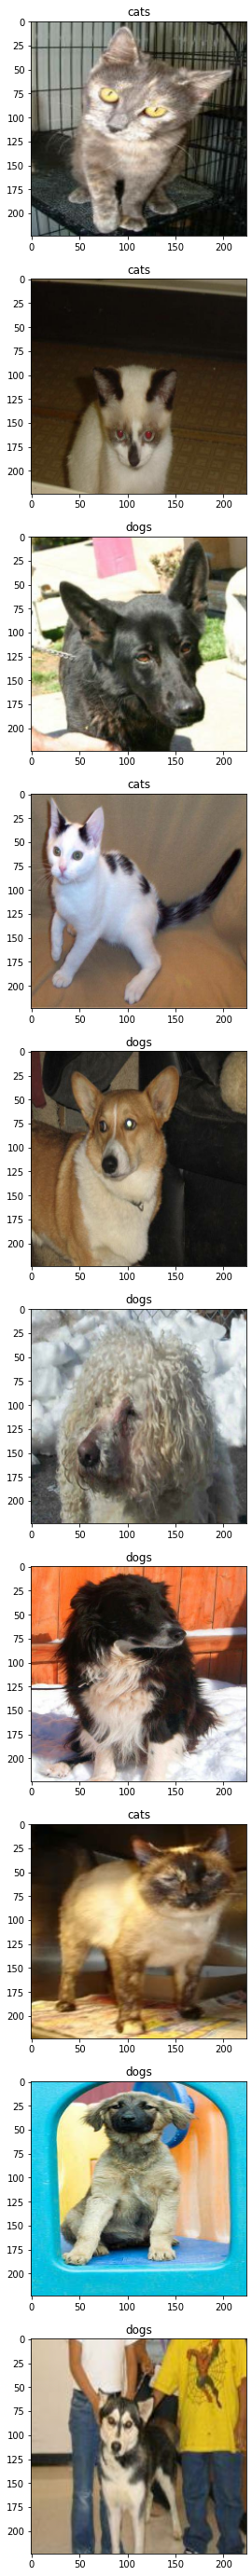

In [ ]:
test_img_locs, test_labels, class_names= get_file_locs_and_labels(TEST_SET_DIR)
test_dataset, steps_per_test_epoch = convert_to_tf_dataset(test_img_locs, test_labels, len(test_img_locs), BATCH_SIZE)

images, labels = next(test_dataset)

fig=plt.figure(figsize=(50, 50))
columns = 1
if BATCH_SIZE>10:
  rows =10
else:
  rows = BATCH_SIZE

for i in range(1, columns*rows +1):
    img = images[i-1]
    cls_index=np.where(labels[i-1].numpy()==1)[0][0]
    fig.add_subplot(rows, columns, i, title = class_names[cls_index])
    plt.imshow(img)
plt.show()


In [ ]:
"""
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same',input_shape=(224, 224, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(64,activation='relu'),
  tf.keras.layers.Dense(32,activation='relu'),
  tf.keras.layers.Dense(16,activation='relu'),
  tf.keras.layers.Dense(len(class_names),activation='softmax')
])
"""
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights="imagenet")
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2,activation='softmax')

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)



In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0075)

In [ ]:
def get_acc(dataset,steps_per_epoch):
    acc_sum =0
    for step in range(steps_per_epoch):
      image_batch, labels_batch = next(dataset)
      pred = model(image_batch, training=False).numpy()
    
      for i ,row in enumerate(pred):
        for j,ele in enumerate(row):
            if ele>0.5:
                pred[i,j]=1
            else:
            
                pred[i,j]=0
            
      dif = labels_batch-pred
    
      dif = np.absolute(dif.numpy()[:,0])
      batch_acc = 1-(np.sum(dif)/BATCH_SIZE)
      #print("Batch acc = ",batch_acc*100,"%")
      acc_sum =acc_sum +batch_acc
    
    return (acc_sum/steps_per_epoch)*100

In [ ]:
test_img_locs, test_labels, class_names = get_file_locs_and_labels(TEST_SET_DIR)
train_img_locs, train_labels, class_names = get_file_locs_and_labels(TRAIN_SET_DIR)
train_dataset, steps_per_train_epoch = convert_to_tf_dataset(train_img_locs, train_labels, len(train_img_locs), BATCH_SIZE)
test_dataset, steps_per_test_epoch = convert_to_tf_dataset(test_img_locs, test_labels, len(test_img_locs), BATCH_SIZE)

print("Steps for a train epoch: ",steps_per_train_epoch)
print("Steps for a test epoch: ",steps_per_test_epoch)
print("Number of epochs: ",EPOCHS)


for epoch in range(EPOCHS):

    

    print(f"Epoch {epoch+1}",end =" ")
    loss_sum = 0

    # Iterate over the batches of the dataset.
    for step in range(steps_per_train_epoch):
        print("-",end ="")
        image_batch, labels_batch = next(train_dataset)

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(image_batch, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            
            loss_value = loss_fn(labels_batch, logits)
            loss_sum = loss_sum + loss_value.numpy()

            
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)
        
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

    print("Number of mini batches:",step)
    print("Training loss:",loss_sum/steps_per_train_epoch)
    print("Train_acc:",get_acc(train_dataset, steps_per_train_epoch),"%")
    print("Test_acc:",get_acc(test_dataset, steps_per_test_epoch),"%")

 

Steps for a train epoch:  81
Steps for a test epoch:  21
Number of epochs:  12
Epoch 1 ---------------------------------------------------------------------------------Number of mini batches: 80
Training loss: 0.08925880106844376
Train_acc: 97.62962962962956 %
Test_acc: 97.61904761904758 %
Epoch 2 ---------------------------------------------------------------------------------Number of mini batches: 80
Training loss: 0.051274471976621834
Train_acc: 99.08641975308637 %
Test_acc: 98.57142857142858 %
Epoch 3 -------------------------

KeyboardInterrupt: ignored

In [ ]:
images, l = next(test_dataset)
pred=model(images).numpy()

for i ,row in enumerate(pred):
    for j,ele in enumerate(row):
        if ele>0.5:
            pred[i,j]=1
        else:
            
            pred[i,j]=0

fig=plt.figure(figsize=(50, 50))
columns = 1
if BATCH_SIZE>10:
  rows =10
else:
  rows = BATCH_SIZE
for i in range(1, columns*rows +1):
    img = images[i-1]
    cls_index=np.where(pred[i-1]==1)[0][0]
    fig.add_subplot(rows, columns, i, title = class_names[cls_index])
    plt.imshow(img)
plt.show()


In [ ]:
model.save_weights(CHECKPOINT_DIR)

In [ ]:
get_acc(test_dataset, steps_per_test_epoch)

In [ ]:
x,y =next(test_dataset)
pred = model(x).numpy()
for i ,row in enumerate(pred):
        for j,ele in enumerate(row):
            if ele>0.5:
                pred[i,j]=1
            else:
            
                pred[i,j]=0

print(pred)
print(y.numpy())